## Starting again with stuff from Hao's notebook ##

In [4]:
!pip install psycopg2

In [1]:
import sys
import pandas as pd
import numpy as np
import datetime
sys.path.append('..\\sif_research\\research_framework')
import metrics
import os
from operators import rank, ts_rank, group_rank, weight


sys.path.append('..\\sif_research\\data_utils')

import sif_utils as su

In [2]:
# Global Variables / Research Environment Settings
start_date = datetime.datetime(day=1, month=1, year=2012)
end_date = datetime.datetime(day=1, month=1, year=2017)
days = (end_date - start_date).days
lookback = 20
delay = 1
top_N = 300
initial_investment = 1000
save_backtest_result = True
backtest_result_folder = './backtest_result'
# Get all tickers
tickers = sorted(su.get_universe_tickers(top_N, start_date, end_date))

In [3]:
# Grab all tickers in the universe and sort them
tickers = sorted(su.get_universe_tickers(top_N, start_date, end_date))
universe_size = len(tickers)

price_attrs = ['open', 'close', 'low', 'high', 'volume']
data = su.get_equity_data(tickers=tickers, start_date=start_date,
                          end_date=end_date, attributes=price_attrs)


In [4]:
OPEN = data['open'].astype(float).values
CLOSE = data['close'].astype(float).values
LOW = data['low'].astype(float).values
HIGH = data['high'].astype(float).values
VOLUME = data['volume'].astype(float).values

# Create universe filter table
all_dates = data['close'].index.values
universe_filter = su.create_universe_filter(top_N, start_date, end_date, tickers, all_dates)

# Grab all tickers in the universe and sort them
tickers = sorted(su.get_universe_tickers(top_N, start_date, end_date))
universe_size = len(tickers)
universe_filter_arr = universe_filter.values

In [5]:
data.keys()

dict_keys(['open', 'close', 'low', 'high', 'volume'])

In [6]:
# Hao's example alpha
def alpha(day):
    # raw factor computed for all tickers (not necesarily the valid universe)
    factor = -rank(CLOSE[day - delay] - CLOSE[day - delay - 4])
    return weight(factor, universe_filter_arr[day])

In [118]:
# The idea of combining gain and acceleration to estimate future returns
# If a stock has had positive returns and high momentum, then we expect that stock to continue performing well

def momentum_alpha(day, gain_lb=4, acc_lb=18):
    #TODO: Add smoothing of data to reduce turnover
    #possible option, if delta of returns is not greater than .....
    
    # Weight acceleration more heavily by squaring it. Numbers below 1 will get smaller and numbers above 1 will get larger. The greater the distance from 1, the more the squaring will afffect it.
    # This means that extremely weak momentum or extremely strong momentum will be accentuated by the squaring and will make us short or long the stock respectively.
    
    acceleration = rank(np.power((CLOSE[day - delay] / CLOSE[day - delay - acc_lb] - 1), 2))
    gain = (CLOSE[day - delay - gain_lb] - CLOSE[day - delay]) / ( CLOSE[day - delay - gain_lb])
    
    # For some reason, setting accel equal to 0 when momentum is greater than 0 improves sharpe ratio (at the expense of slightly higher turnover)
#     acceleration[gain < 0] = 0

    weekly_gain = rank(gain)
    
    factor = weekly_gain + acceleration

    weights = weight(factor, universe_filter_arr[day])
    # Dropping weights less than arbitrary value to lower turnover
    # Lower returns but also MUCH lower turnover
    weights[np.abs(weights) < .006] = 0
    return weights

           return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2012     0.056877  1.833256  3.054017 -0.016923  0.368168   29.034483   
2013     0.029961  1.330725  2.031778 -0.020728  0.371379   28.861111   
2014     0.049864  1.697847  2.695571 -0.022343  0.373420   29.083333   
2015     0.028681  0.770785  1.143886 -0.021639  0.367005   29.353175   
2016     0.073152  1.854104  3.063458 -0.029175  0.377151   29.318725   
Overall  0.233732  1.462297  2.313722 -0.034715  0.371716   29.132258   

         short count  
year                  
2012       21.409483  
2013       22.214286  
2014       21.611111  
2015       20.496032  
2016       22.386454  
Overall    21.629839  


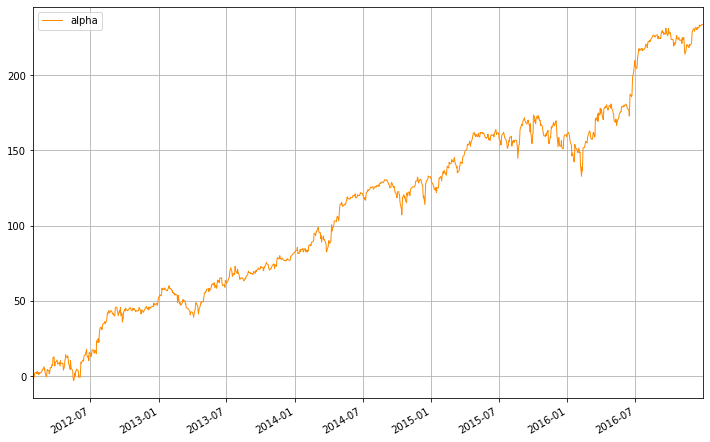

In [119]:
# run backtest, print the performance table and draw the chart
# For skew momentum
lookback = 18
holdings = metrics.backtest(momentum_alpha, CLOSE.shape[0], universe_size, lookback)
daily_returns = metrics.daily_return(holdings[:-1], OPEN[lookback:] )
performance = metrics.generate_performance_table(daily_returns, holdings,
                                                 dates=all_dates[lookback:-1],
                                                tickers=tickers)
print(performance)
# print(performance['return'].iloc[5])
pnl_df = pd.DataFrame(daily_returns.cumsum() * initial_investment,index = data['close'].iloc[lookback:-1].index, columns = ['alpha'])
chart = pnl_df.plot(grid=True,figsize=[12,8],linewidth=1,color='darkorange')


In [120]:
momentum_alpha(70)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00757744,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00657892,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00731825,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [15]:
def test_diff_lookbacks(gain_lbs=[4], acc_lbs=[18]):
    for gain_lb in gain_lbs:
        for acc_lb in acc_lbs:
            def momentum_alpha(day):
                acceleration = rank(np.power((CLOSE[day - delay] / CLOSE[day - delay - acc_lb] - 1), 2))
                weekly_gain = -rank(CLOSE[day - delay] - CLOSE[day - delay - gain_lb])

                factor = weekly_gain + acceleration
                return weight(factor, universe_filter_arr[day])
            # run backtest, print the performance table and draw the chart
            # For skew momentum
            lookback = acc_lb
            holdings = metrics.backtest(momentum_alpha, CLOSE.shape[0], universe_size, lookback)
            daily_returns = metrics.daily_return(holdings[:-1], OPEN[lookback:] )
            performance = metrics.generate_performance_table(daily_returns, holdings,
                                                             dates=all_dates[lookback:-1],
                                                            tickers=tickers)
            print(f'Gain lb: {gain_lb}, Acc lb: {acc_lb}')
            rets = performance['return'].iloc[5]
            shp = performance['sharpe'].iloc[5]
            srt = performance['sortino'].iloc[5]
            trn_ovr = performance['turnover'].iloc[5]
            print(f'Total returns: {rets} , Sharpe: {shp} , Sortino: {srt}, Turnover {trn_ovr}')

            
gain_lbs=[3, 4, 5, 6, 7, 8, 9, 10]
acc_lbs=[10,12,13,14,15,16,17,18,20,25,30, 35, 40]
test_diff_lookbacks(gain_lbs, acc_lbs)


# pnl_df = pd.DataFrame(daily_returns.cumsum() * initial_investment,index = data['close'].iloc[lookback:-1].index, columns = ['alpha'])
# chart = pnl_df.plot(grid=True,figsize=[12,8],linewidth=1,color='darkorange')


C:\Users\erueb\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Gain lb: 3, Acc lb: 10
Total returns: 0.20755878264486877 , Sharpe: 1.132558536420329 , Sortino: 1.7099859408466949, Turnover 0.7811114261474649
Gain lb: 3, Acc lb: 12
Total returns: 0.194252563794313 , Sharpe: 1.0650599817964468 , Sortino: 1.6076264917956593, Turnover 0.7561692689599129
Gain lb: 3, Acc lb: 13
Total returns: 0.179676098569025 , Sharpe: 0.9830773201800953 , Sortino: 1.4701771680975206, Turnover 0.7481294443176008
Gain lb: 3, Acc lb: 14
Total returns: 0.16797529352764815 , Sharpe: 0.9253678156965537 , Sortino: 1.3925667457186415, Turnover 0.7378552756736234
Gain lb: 3, Acc lb: 15
Total returns: 0.16766248605846698 , Sharpe: 0.9101847394081892 , Sortino: 1.3632409412160962, Turnover 0.7313301428056074
Gain lb: 3, Acc lb: 16
Total returns: 0.1681904169714486 , Sharpe: 0.9176668312861173 , Sortino: 1.3848115556355494, Turnover 0.7208017448497601
Gain lb: 3, Acc lb: 17
Total returns: 0.18232934473609563 , Sharpe: 0.9971636920955514 , Sortino: 1.5152720635041816, Turnover 0.7

KeyboardInterrupt: 

In [35]:
def skew_momentum_alpha(day):
    # Using the max daily return from the past 3 months to represent skew
#     print(day)
    skew_start = day - delay - 20
    skew_end = day
#     print(f'Skew start: {skew_start} , skew end: {skew_end}')
    daily_rets = CLOSE[skew_start:skew_end] - OPEN[skew_start:skew_end]
    
    skew = rank(np.amax(daily_rets, axis=0))

    # Using return from the past 3 months as momentum
    momentum = rank(CLOSE[day - delay] / CLOSE[day - delay - 252])

    # We believe that stocks with either high skew and negative momentum OR stocks with low skew and positive momentum are the stocks we want to long
    # These stocks are said to have "enhanced momentum"
    # High skew neg momentum signifies a stock that is currently undervalued?, as in its current pricing represents a negative outlier value and it will revert to the mean
    # Low skew pos momentum signifies a stock that is currently performing well and appears to be performing around its average, therefore this stock is a good buy as 
    #    we expect it to continue on this trend

    # Simple and likely nonoptimal way to try to find these stocks with mixed skew/momentum high/low or low/high is to add their ranked arrays together
        # Side note, could weight the momentum vs. skew arrays differently to see if that changes anything
    # Since the rankings are both equal, (rank assigns a percentile to each ticker), The combination of skew/momentum high/high will be closer to 2 and low/low will be closer to 0, 
    # so we want middling values

    # In a simple effort to address this, we rank the values in the combined array of skew and momentum by each elements absolute difference from 1
    # (i.e. -rank by abs diff to ensure that the lowest abs diff is ranked highest)
#         combined = skew + momentum
#     #     print(combined)
#         factor = -rank(abs(combined - 1))
#         return weight(factor, universe_filter_arr[day])

    # Trying paper's approach for ranking
    # Take stocks that are in the top quintile of skew and bottom quintile of momentum or in the bottom quintile of skew and top quintile of momentum
    factor = np.zeros(len(skew))
#     print(skew)
#     print(momentum)
    for i in range(0, len(skew)):
        if((skew[i] >= .8 and momentum[i] <= .2) or (skew[i] <= .2 and momentum[i] >= .8)):
            # Long the stock
            factor[i] = abs(skew[i] - momentum[i])
        else:
            factor[i] = 0
    # Inverting the factor gives much better returns???
    # Did I get something backwards???
    return weight(factor, universe_filter_arr[day])

In [14]:
def test_diff_skew_momentum(gain_lbs=[4], acc_lbs=[18]):
    def skew_momentum_alpha(day):
        skew_start = day - delay - 20
        skew_end = day
        daily_rets = CLOSE[skew_start:skew_end] - OPEN[skew_start:skew_end]

        skew = rank(np.amax(daily_rets, axis=0))

        momentum = rank(CLOSE[day - delay] / CLOSE[day - delay - 252])
        factor = np.zeros(len(skew))
        for i in range(0, len(skew)):
            if((skew[i] >= .8 and momentum[i] <= .2) or (skew[i] <= .2 and momentum[i] >= .8)):
                factor[i] = abs(skew[i] - momentum[i])
            else:
                factor[i] = 0
        return weight(factor, universe_filter_arr[day])
    
    
    holdings = metrics.backtest(momentum_alpha, CLOSE.shape[0], universe_size, lookback)
    daily_returns = metrics.daily_return(holdings[:-1], OPEN[lookback:] )
    performance = metrics.generate_performance_table(daily_returns, holdings,
                                                     dates=all_dates[lookback:-1],
                                                    tickers=tickers)
    print(f'Gain lb: {gain_lb}, Acc lb: {acc_lb}')
    rets = performance['return'].iloc[5]
    shp = performance['sharpe'].iloc[5]
    srt = performance['sortino'].iloc[5]
    trn_ovr = performance['turnover'].iloc[5]
    print(f'Total returns: {rets} , Sharpe: {shp} , Sortino: {srt}, Turnover {trn_ovr}')

            
gain_lbs=[3, 4, 5, 6, 7, 8, 9, 10]
acc_lbs=[10,12,13,14,15,16,17,18,20,25,30, 35, 40]
test_diff_skew_momentum()


# pnl_df = pd.DataFrame(daily_returns.cumsum() * initial_investment,index = data['close'].iloc[lookback:-1].index, columns = ['alpha'])
# chart = pnl_df.plot(grid=True,figsize=[12,8],linewidth=1,color='darkorange')


C:\Users\erueb\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Gain lb: 3, Acc lb: 10
Total returns: 0.19488975560502164 , Sharpe: 1.0734992428185743 , Sortino: 1.6154413928153628, Turnover 0.7808227605847979
Gain lb: 3, Acc lb: 12
Total returns: 0.1854971657153981 , Sharpe: 1.0241030610842483 , Sortino: 1.5432000146514735, Turnover 0.7556459231708186
Gain lb: 3, Acc lb: 13
Total returns: 0.17577622663339082 , Sharpe: 0.9664216142418761 , Sortino: 1.444622887150427, Turnover 0.747793227861756


KeyboardInterrupt: 

In [ ]:
# The idea is to include returns, change in returns, and change in change in returns as stats to look at 
def convex_concave(day):
    

In [13]:
def long_all(day):
    all_long = np.zeros(318)
    all_long.fill(1/300)
    return all_long

In [34]:
skew_momentum_alpha(346)

array([ 0.        , -0.00180505, -0.00180505,  0.        ,  0.        ,
       -0.00180505, -0.00180505, -0.00180505,  0.        , -0.00180505,
       -0.00180505, -0.00180505,  0.        , -0.00180505,  0.        ,
       -0.00180505, -0.00180505, -0.00180505,  0.        ,  0.        ,
        0.        , -0.00180505, -0.00180505,  0.        , -0.00180505,
       -0.00180505, -0.00180505, -0.00180505,  0.02173913, -0.00180505,
       -0.00180505, -0.00180505,  0.        , -0.00180505,  0.        ,
        0.        ,  0.        , -0.00180505, -0.00180505,  0.        ,
       -0.00180505,  0.        ,  0.02173913, -0.00180505, -0.00180505,
        0.        , -0.00180505, -0.00180505, -0.00180505,  0.02173913,
        0.        , -0.00180505, -0.00180505, -0.00180505, -0.00180505,
        0.02173913, -0.00180505, -0.00180505, -0.00180505, -0.00180505,
       -0.00180505, -0.00180505, -0.00180505, -0.00180505, -0.00180505,
        0.        , -0.00180505,  0.        ,  0.02173913, -0.00


## TOP 300 STOCKS
### POSITIVE LOOKING NUMBERS ##

Gain lb: 4, Acc lb: 18

Total returns: 0.2382934958199166 , Sharpe: 1.2804265794353327 , Sortino: 1.9797770886920847, Turnover 0.6521009895640726

Gain lb: 4, Acc lb: 20

Total returns: 0.20310126440176596 , Sharpe: 1.0802058985497824 , Sortino: 1.6555270393783252, Turnover 0.640640241958349

Gain lb: 4, Acc lb: 25

Total returns: 0.21252520383274218 , Sharpe: 1.1269014278882434 , Sortino: 1.7166351306188292, Turnover 0.6196802022986341

Gain lb: 4, Acc lb: 30

Total returns: 0.23246141204533602 , Sharpe: 1.2382039738994808 , Sortino: 1.9045470095089285, Turnover 0.6023572866546534


In [80]:
# Can do something with close to open overnight
def overnight(day):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-80-d8fb8771adf2>, line 3)

### Some notes from meeting 2/24/2020 to possibly make alphas ### 

 Momentum again from video from 2/24/2020
 
 Look at convexity and concavity
 
 y = Gain * t + Acc * x^2
 
 Accelerated vs decelerated gain
 
 Whether coefficients are positive or negative
 
 Approximating curves with polynomials

 Skewness and momentum
 Skewness as a signal for stocks that are overbrought

Proxy for skew, max daily return from past 20 days/ past month (positive skew)
    Could also do negative skew with minimum

Assume return over trailing year as momentum

More strongly positive skew and positive momentum represents weakened momentum

Positive momentum and less skew is enhanced momentum

Negativee momentum and positive skew is enhanced momentum

Negative momenutum and less skew is weakened momentum

Ideas for fundamanetal frm Hao
   
   Rank ( equity/ assets) <-- cross sectional
   
   ts_rank(-debt/equity, 252 <-- or whatever lookback) <-- ts_info
   
   abs(eps[day - 1] - eps[day - 2]) > 0 <-- check to see if comany updated financial statements
   
       Include mean reversion/momentum factor and combine with this to build an alpha

           return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2012     0.056877  1.833256  3.054017 -0.016923  0.368168   29.034483   
2013     0.029961  1.330725  2.031778 -0.020728  0.371379   28.861111   
2014     0.049864  1.697847  2.695571 -0.022343  0.373420   29.083333   
2015     0.028681  0.770785  1.143886 -0.021639  0.367005   29.353175   
2016     0.073152  1.854104  3.063458 -0.029175  0.377151   29.318725   
Overall  0.233732  1.462297  2.313722 -0.034715  0.371716   29.132258   

         short count  
year                  
2012       21.409483  
2013       22.214286  
2014       21.611111  
2015       20.496032  
2016       22.386454  
Overall    21.629839  


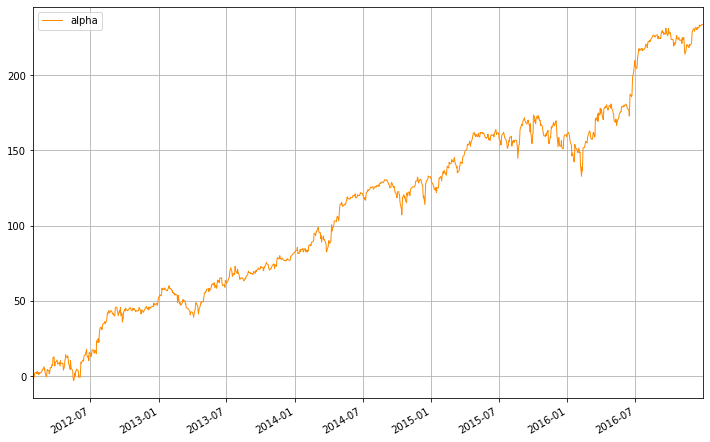

In [121]:
# run backtest, print the performance table and draw the chart
# For skew momentum
lookback = 18
holdings = metrics.backtest(momentum_alpha, CLOSE.shape[0], universe_size, lookback)
daily_returns = metrics.daily_return(holdings[:-1], OPEN[lookback:] )
performance = metrics.generate_performance_table(daily_returns, holdings,
                                                 dates=all_dates[lookback:-1],
                                                tickers=tickers)
print(performance)
# print(performance['return'].iloc[5])
pnl_df = pd.DataFrame(daily_returns.cumsum() * initial_investment,index = data['close'].iloc[lookback:-1].index, columns = ['alpha'])
chart = pnl_df.plot(grid=True,figsize=[12,8],linewidth=1,color='darkorange')


In [ ]:
## PRODUCES SHARPE 1.45, TURNOVER .68

# The idea of combining gain and acceleration to estimate future returns
# If a stock has had positive returns and high momentum, then we expect that stock to continue performing well

def momentum_alpha(day, gain_lb=4, acc_lb=18):
    #TODO: Add smoothing of data to reduce turnover
    #possible option, if delta of returns is not greater than .....
    
    # Weight acceleration more heavily by squaring it. Numbers below 1 will get smaller and numbers above 1 will get larger. The greater the distance from 1, the more the squaring will afffect it.
    # This means that extremely weak momentum or extremely strong momentum will be accentuated by the squaring and will make us short or long the stock respectively.
    
    acceleration = rank(np.power((CLOSE[day - delay] / CLOSE[day - delay - acc_lb] - 1), 2))
    gain = (CLOSE[day - delay - gain_lb] - CLOSE[day - delay]) / ( CLOSE[day - delay - gain_lb])
#     print(gain)
    acceleration[gain < 0] = 0
#     print(gain)
    weekly_gain = rank(gain)
    
    factor = weekly_gain + acceleration
    return weight(factor, universe_filter_arr[day])

In [122]:
# save backtest result
if save_backtest_result == True:
    if not os.path.exists(backtest_result_folder):
        os.makedirs(backtest_result_folder)
    pnl_df.to_csv(backtest_result_folder+'/'+'pnl.csv')
    pd.DataFrame(holdings[:-1],index = data['close'].iloc[lookback:-1].index, columns = tickers).to_csv(backtest_result_folder+'/'+'holdings.csv')
    chart.get_figure().savefig(backtest_result_folder+'/'+'performance.png')
        